In [65]:
#Import libraries
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import galsim
import time
#from galsim.gsparams import GSParams
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import shape_measurement as sm
import cPickle

In [124]:
fil=open('/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/measErrs.pkl')
res=cPickle.load(fil)
fil.close()


In [125]:
sde1, sde2, hlr, sn, q = res
nanI = np.where(np.isnan(sde1))[0]
assert np.all(nanI == np.where(np.isnan(sde2))[0])
sde1, sde2, hlr, sn, q = [np.delete(i,nanI) for i in res]
ind = range(len(sde1))

0.0 0.5111308693885803


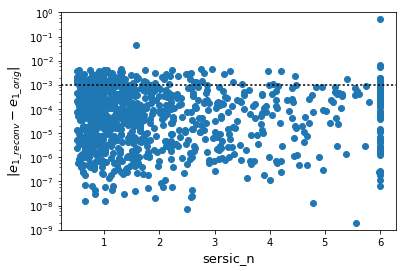

In [150]:
xoptions={'q':q,'hlr':hlr,'sersic_n':sn}
xchoice='sersic_n'
xarr = xoptions[xchoice]
yarr = sde1
if np.all(yarr==sde1):
    ylabel='$|e_{1\_reconv}-e_{1\_orig}|$'
else:
    ylabel='$|e_{2\_reconv}-e_{2\_orig}|$'
fig,ax=plt.subplots()
plt.scatter(xarr,yarr)
print np.nanmin(yarr),np.nanmax(yarr)
plt.ylim(1e-9,1e-0)
ax.set_yscale('log')
plt.ylabel(ylabel,size=13)
plt.xlabel(xchoice,size=13)
#plt.xlim(0,100)
#ax.set_xscale('log')
plt.axhline(1e-3,linestyle=':',c='k')
#plt.savefig('/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/errs_vs_'+xchoice+'.png')

In [121]:
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# cut=sde1>1e-3
# ax.scatter(sn[cut],q[cut],np.log10(sde1[cut]),c='b')
# ax.scatter(sn[~cut],q[~cut],np.log10(sde1[~cut]),c='r')

#ax.set_xlim(0,100)


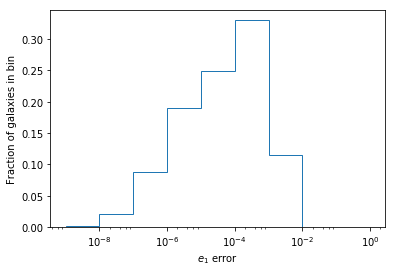

In [155]:
fig,ax=plt.subplots()
arr = sde1

weights = np.ones_like(arr)/float(len(arr))
hist1,bins1,patch=plt.hist(arr, bins=np.logspace(-9,0, 10),histtype='step',weights=weights)
ax.set_xscale('log')
plt.xlabel('$e_1$ error')
plt.ylabel('Fraction of galaxies in bin')
#plt.savefig('/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/e1_err_hist.png')
#ax.set_yscale('log')

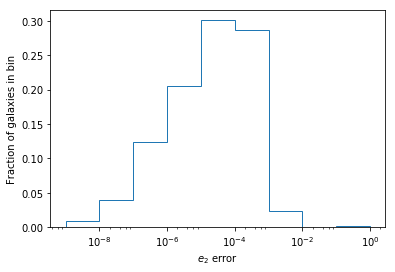

In [156]:
fig,ax=plt.subplots()
arr = sde2

weights = np.ones_like(arr)/float(len(arr))
hist1,bins1,patch=plt.hist(arr, bins=np.logspace(-9,0, 10),histtype='step',weights=weights)
ax.set_xscale('log')
plt.xlabel('$e_2$ error')
plt.ylabel('Fraction of galaxies in bin')
#plt.savefig('/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/e2_err_hist.png')
#ax.set_yscale('log')